In [57]:
import os
import sys
import cv2
import operator
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from skimage.feature import hog
from skimage.future import graph
from skimage.segmentation import slic, mark_boundaries
from skimage.filters import threshold_multiotsu, try_all_threshold, threshold_li


from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Dataset description : 

We'll Use the BraTS dataset comprised of 295 MRI scans (155 slides) from the Brain Tumor Segmentation challenge 2020 

The annotation covers three different layers : Nectrotic non enhancing tumor, Enhancing tumor and surrounding edema.

In [59]:
# Directory of The Dataset : 
DIR = fr"C:/Users/ahoud/Documents/Cours ECP/3A/IGR/Scripts/dataset/"


# Fonction to write 1 as 001, 10 as 010 and 100 as 100:
def shape(n):
    return "0" * (3 - len(str(n))) + str(n)

# Function to return a certain slice of an MRI from the Dataset :
def get_slice_mri(mri, slice=62, gray=True):
        
    dir_train_img = fr"{DIR}/train_image/BraTS20_Training_{shape(mri)}_t1ce/BraTS20_Training_{shape(mri)}_t1ce_{str(slice)}.jpg"
    
    dir_label_img = fr"{DIR}/train_label/BraTS20_Training_{shape(mri)}_seg/BraTS20_Training_{shape(mri)}_seg_{str(slice)}.jpg"
    
       
    img_train = cv2.imread(dir_train_img, cv2.COLOR_BGR2GRAY) if gray else cv2.imread(dir_train_img)
    
    img_label = cv2.imread(dir_label_img, cv2.COLOR_BGR2GRAY)
    img_label = img_label.astype(np.float32)
    # Amend the values of img_label : 
    img_label[np.abs(img_label)       <= 10] = 0
    img_label[np.abs(img_label -  50) <= 10] = 50
    img_label[np.abs(img_label - 100) <= 10] = 100
    img_label[np.abs(img_label - 200) <= 10] = 200
    img_label = img_label.astype(np.uint8)
    
    return img_train, img_label


In [60]:
# Plot slice of MRI and its segmentation : 
def plot_slice_mri(mri=1, slice=62, pred_gray=True):
    
    img_train, img_label = get_slice_mri(mri, slice)
        
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].imshow(img_train, cmap="gray")
    
    ax[0].set_title("training image")
    
    ax[1].imshow(img_label, cmap="gray")
    
    ax[1].set_title("segmentation")
    
    plt.show()

In [61]:
def compare_pred_seg(img_train, img_label, img_pred, pred_title="model segmentation", pred_gray=True):
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    color_map = {"cmap": "gray"} if pred_gray else {}
    
    ax[0].imshow(img_train, cmap="gray")
    
    ax[0].set_title("training image")
    
    ax[1].imshow(img_pred, **color_map)
    
    ax[1].set_title(pred_title)

    ax[2].imshow(img_label, cmap="gray")
    
    ax[2].set_title("segmentation")
    
    plt.show()    

for the next parts of this note book, we'll use segmentation techniques on the 62-nd slice from the first mMRI :   

In [62]:
img_train, img_label = get_slice_mri(1, 62)

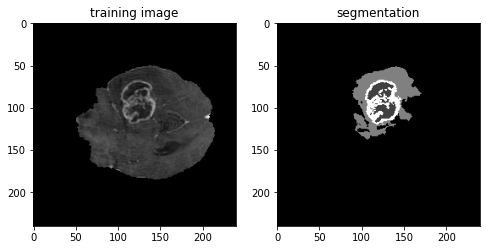

In [63]:
plot_slice_mri(1, 62)

## Segmentation methods based on contour : 

#### using Laplacian filter : 

    --------------------------       Apply Laplacian Filter      --------------------------


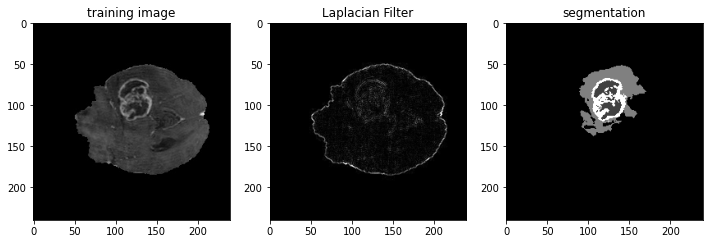

In [64]:
# Apply Laplacian filter :

img_laplacian = cv2.Laplacian(img_train, cv2.CV_64F)

img_laplacian = cv2.convertScaleAbs(img_laplacian) 

print("    --------------------------       Apply Laplacian Filter      --------------------------")

compare_pred_seg(img_train, img_label, img_laplacian, pred_title="Laplacian Filter")


#### Apply Sobel filter : 

    --------------------------       Apply Sobel Filter on x     --------------------------


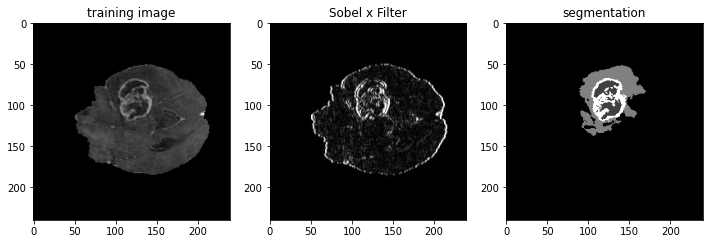

    --------------------------       Apply Sobel Filter on y     --------------------------


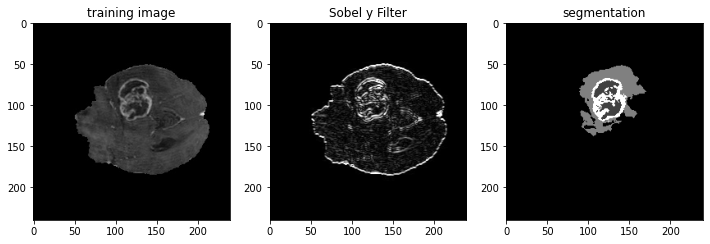

    --------------------------          Sobel Magnitude          --------------------------


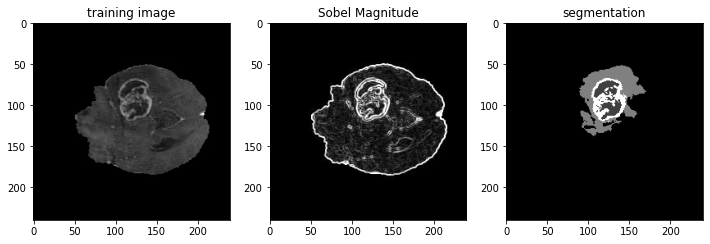

In [65]:
img_sobel_x = cv2.Sobel(img_train, cv2.CV_64F, 1, 0, ksize=3)

img_sobel_y = cv2.Sobel(img_train, cv2.CV_64F, 0, 1, ksize=3)

img_sobel_mag = np.sqrt(img_sobel_x ** 2 + img_sobel_y ** 2)

print("    --------------------------       Apply Sobel Filter on x     --------------------------")

img_sobel_x = cv2.convertScaleAbs(img_sobel_x) 

compare_pred_seg(img_train, img_label, img_sobel_x, pred_title="Sobel x Filter")

print("    --------------------------       Apply Sobel Filter on y     --------------------------")

img_sobel_y = cv2.convertScaleAbs(img_sobel_y) 

compare_pred_seg(img_train, img_label, img_sobel_y, pred_title="Sobel y Filter")

print("    --------------------------          Sobel Magnitude          --------------------------")

img_sobel_mag = cv2.convertScaleAbs(img_sobel_mag) 

compare_pred_seg(img_train, img_label, img_sobel_mag, pred_title="Sobel Magnitude")

#### Apply scharr filter : 

    --------------------------       Apply Scharr Filter on x     --------------------------


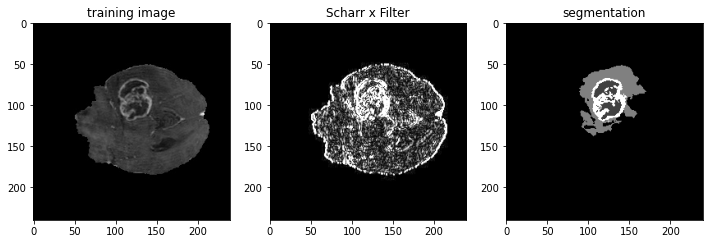

    --------------------------       Apply Scharr Filter on y     --------------------------


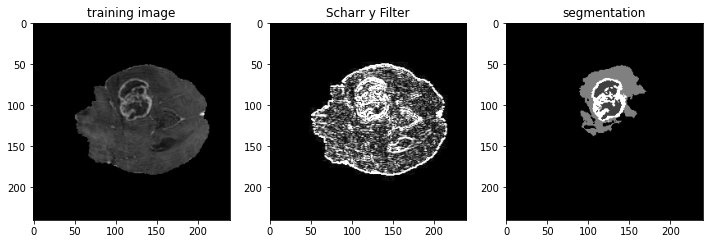

    --------------------------          Scharr Magnitude          --------------------------


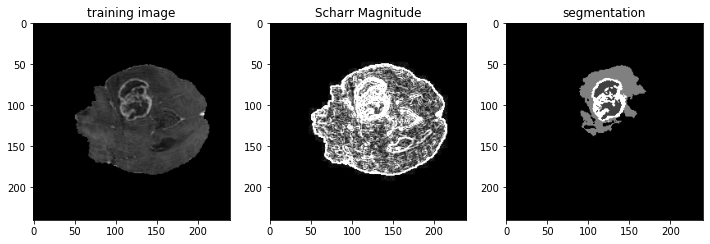

In [66]:
img_scharr_x = cv2.Scharr(img_train, cv2.CV_64F, 1, 0)

img_scharr_y = cv2.Scharr(img_train, cv2.CV_64F, 0, 1)

img_scharr_mag = np.sqrt(img_scharr_x ** 2 + img_scharr_y ** 2)

print("    --------------------------       Apply Scharr Filter on x     --------------------------")

img_scharr_x = cv2.convertScaleAbs(img_scharr_x) 

compare_pred_seg(img_train, img_label, img_scharr_x, pred_title="Scharr x Filter")

print("    --------------------------       Apply Scharr Filter on y     --------------------------")

img_scharr_y = cv2.convertScaleAbs(img_scharr_y) 

compare_pred_seg(img_train, img_label, img_scharr_y, pred_title="Scharr y Filter")

print("    --------------------------          Scharr Magnitude          --------------------------")

img_scharr_mag = cv2.convertScaleAbs(img_scharr_mag) 

compare_pred_seg(img_train, img_label, img_scharr_mag, pred_title="Scharr Magnitude")

#### Apply Canny Edge Detector : 

    --------------------------      Using Canny Edge Detector    --------------------------


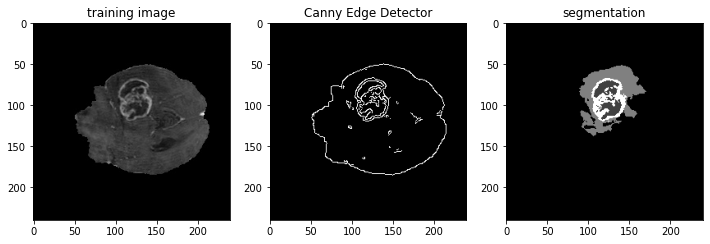

In [67]:
img_canny = cv2.Canny(img_train, 150, 200)

print("    --------------------------      Using Canny Edge Detector    --------------------------")

compare_pred_seg(img_train, img_label, img_canny, pred_title="Canny Edge Detector")

#### Apply Harris Corner Detector : 

    ------------------------      Using Harris Corner Detector    --------------------------


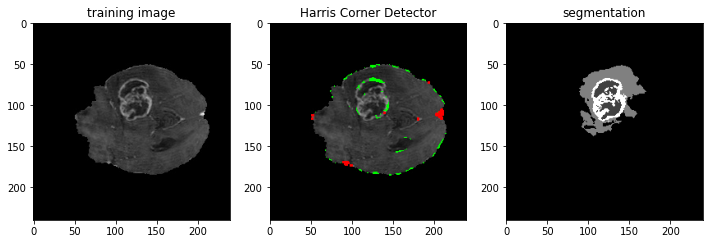

In [68]:
img_harris = cv2.merge([img_train, img_train, img_train])

dst_harris = cv2.cornerHarris(img_train, ksize=3, blockSize= 3, k=0.05, )

dst_harris = cv2.dilate(dst_harris, None)

threshold_edge, threshold_corner = 0.001, 0.01

# Threshold for an optimal value, it may vary depending on the image.
img_harris[dst_harris > threshold_corner * dst_harris.max()] = [255, 0,   0]

img_harris[dst_harris < threshold_edge * dst_harris.min()]   = [  0, 255, 0]

print("    ------------------------      Using Harris Corner Detector    --------------------------")

compare_pred_seg(img_train, img_label, img_harris, pred_title="Harris Corner Detector", pred_gray=False)

## Segmentation methods based on regions : 

###   Thresholding based algorithm : 

### Pre-processing Step  : 

#### Noise removal : 

In [69]:
# Configurations of noise filters : 
NOISE_REMOVAL = {
                    "average"   : {"ddepth":     -1, "kernel": np.ones((3, 3)) / 9},
                    "gaussian"  : {"ksize" : (3, 3), "sigmaX": 0.1                },
                    "median"    : {"ksize" :3                                     },
                    "bilateral" : {"d": 3     , "sigmaColor": 25, "sigmaSpace": 10},
                    "none"      : {}
                }


In [70]:
def denoise(img, method="gaussian"):
    
    params = NOISE_REMOVAL[method]
    
    if method == "average": 
        return cv2.filter2D(img, **params)
    
    elif method == "gaussian":
        return cv2.GaussianBlur(img, **params)
    
    elif method == "median":
        return cv2.medianBlur(img, **params)
    
    elif method == "bilateral":
        return cv2.bilateralFilter(img, **params)
    
    elif method == "none":
        return img
    
    else:
        raise ValueError(f"{method} not in {list(NOISE_REMOVAL.keys())}")
    

 ------------------   Using Gaussian Filter : ------------------ 


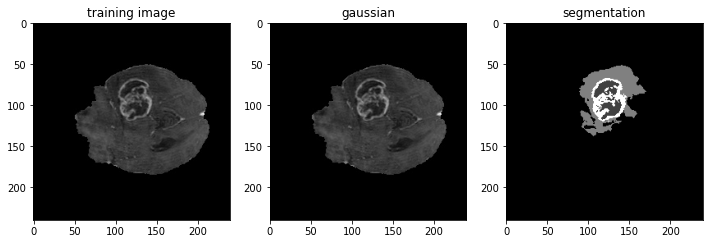

In [71]:
print(" ------------------   Using Gaussian Filter : ------------------ ")
img_noise = denoise(img_train, method="gaussian")

compare_pred_seg(img_train, img_label, img_noise, pred_title="gaussian")

#### Sharpening : 

In [72]:
SHARPENING = [
    "vanilla",
    "laplacian",
    "sobel",
    "scharr",
    "canny",
    "none"
]

In [73]:
def sharpen(img, method="vanilla"):
    
    if method == "vanilla":
        
        kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]], np.float32)        
        return cv2.filter2D(img, -1, kernel)
    
    
    elif method == "laplacian":
        
        img_laplacian = cv2.Laplacian(img_train, cv2.CV_64F)
        return cv2.convertScaleAbs(img_laplacian)
    
        
    elif method == "sobel":
        
        img_sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        img_sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        
        img_sobel_mag = np.sqrt(img_sobel_x ** 2 + img_sobel_y ** 2)
        return cv2.convertScaleAbs(img_sobel_mag)
    
    elif method == "scharr":
            
        img_scharr_x = cv2.Scharr(img, cv2.CV_64F, 1, 0)
        img_scharr_y = cv2.Scharr(img, cv2.CV_64F, 0, 1)

        img_scharr_mag = np.sqrt(img_scharr_x ** 2 + img_scharr_y ** 2)
        return cv2.convertScaleAbs(img_scharr_mag)
    
    elif method == "canny":
        return cv2.Canny(img, 200, 200)
    
    elif method == "none":
        return img
    
    else: 
        raise ValueError(f"{method} not in {SHARPENING} !")


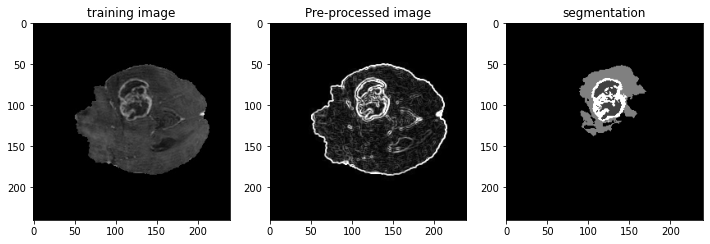

In [74]:
img_train, img_label = get_slice_mri(1, 62)
# Remove the noise : 
denoised  = denoise(img_train, method="gaussian") 
# Sharpen the image : 
sharpened = sharpen(denoised, method="sobel")
# Plot the image : 
compare_pred_seg(img_train, img_label, sharpened, pred_title="Pre-processed image")

#### Adjust contrast : 

In [75]:
ADJUST_CONTRASTS = {
    "histogram" : None,
    "clahe"     : None,  
    "sigmoid"   : {"K1": 10, "K2": 50},
    "none"      : None
}

In [76]:
def modified_sigmoid(z, K1, K2):
    return z + K1 * (z / (1 - np.exp(K1 * (K2 + z))))

def adjust_contrast(img, method=""):
    
    params = ADJUST_CONTRASTS[method]
    
    if method == "histogram": 
        return cv2.equalizeHist(img)
        
    elif method == "clahe":
        return cv2.createCLAHE().apply(img)
    
    elif method == "sigmoid":
        modified_img = modified_sigmoid(img / 255, **params)
        modified_img = (modified_img * 255).astype(np.uint8)
        return cv2.createCLAHE().apply(modified_img)
            
    elif method == "none":
        return img
    
    else:
        raise ValueError(f"{method} not in {ADJUST_CONTRASTS}")
    pass

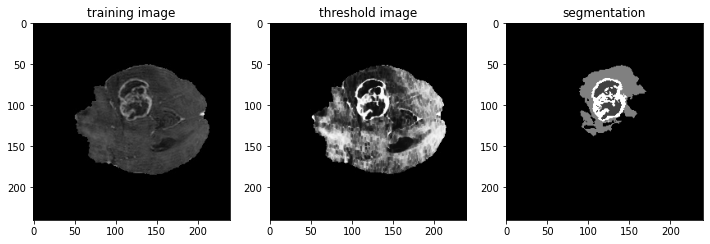

In [77]:
img_train, img_label = get_slice_mri(1, 62)

adjusted  = adjust_contrast(img_train, method="histogram")
sharpened = sharpen(adjusted, method="none") 

kernel    = np.ones((3), np.uint8) 
morph     = cv2.morphologyEx(sharpened, cv2.MORPH_ERODE, kernel)



compare_pred_seg(img_train, img_label, morph, pred_title="threshold image")

### Processing Step  : 

#### Threshold segmentation : 

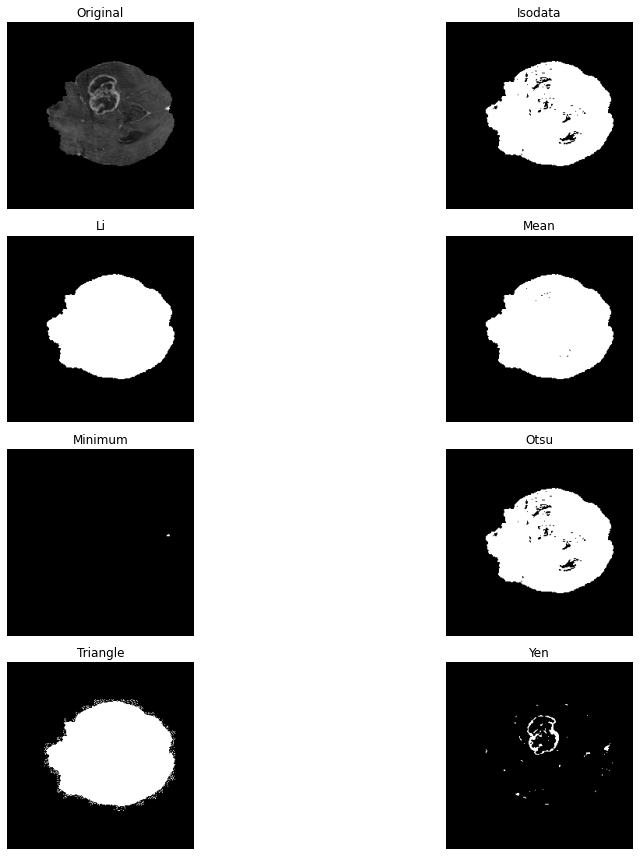

In [78]:
fig, ax = try_all_threshold(img_train, figsize=(16, 12), verbose=False)
plt.show()

In [79]:
THRESHOLDING = {
    "binary"             : {"thresh"  : 80, "maxval": 255, "type": cv2.THRESH_BINARY},
    "binary_inv"         : {"thresh"  : 80, "maxval": 255, "type": cv2.THRESH_BINARY_INV},
    "otsu"               : {"thresh"  : 80, "maxval": 255, "type": cv2.THRESH_BINARY | cv2.THRESH_OTSU},
    "adaptative_mean"    : {"maxValue": 255, "adaptiveMethod": cv2.ADAPTIVE_THRESH_MEAN_C, "thresholdType": cv2.THRESH_BINARY, "blockSize": 7, "C": 25},
    "adaptative_gaussian": {"maxValue": 255, "adaptiveMethod": cv2.ADAPTIVE_THRESH_GAUSSIAN_C, "thresholdType": cv2.THRESH_BINARY, "blockSize": 7, "C": 25},
    "multi_otsu"         : {"classes" : 3},
    "li"                 : None,
            }

In [80]:
def thresholding(img, method="", thresh=80):
    
    params = THRESHOLDING[method]
    
    if method == "binary" or method == "otsu" or method == "binary_inv":
        params["thresh"] = thresh
        return cv2.threshold(img, **params) [1]
    elif method =="li":
        li_thresh = threshold_li(img)
        return img > li_thresh
    
    elif method == "adaptative_mean" or method == "adaptative_gaussian":
        return cv2.adaptiveThreshold(img, **params)
    elif method == "multi_otsu": 
        thresholds = threshold_multiotsu(img, **params)
        return np.digitize(img, bins=thresholds)
    
    else:
        raise ValueError(f"{method} not in {THRESHOLDING} !")
    

Let's now use threshold methods to distinguish between the different parts of the tumor : 

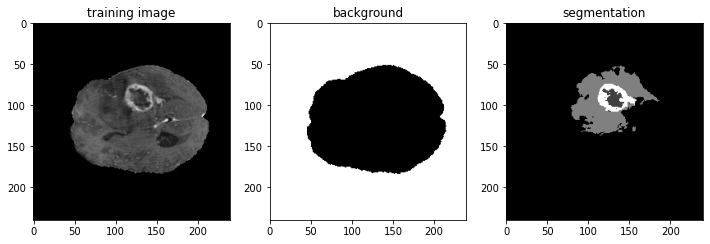

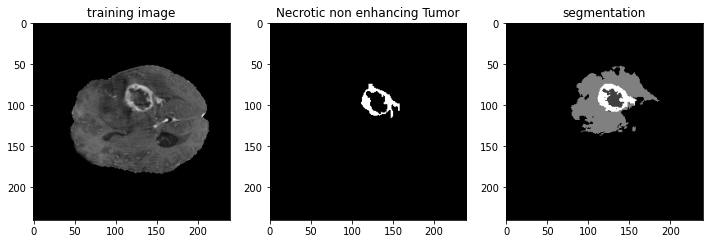

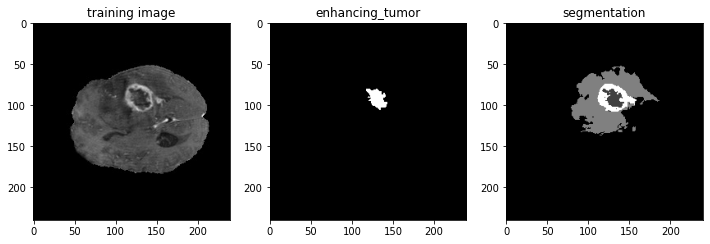

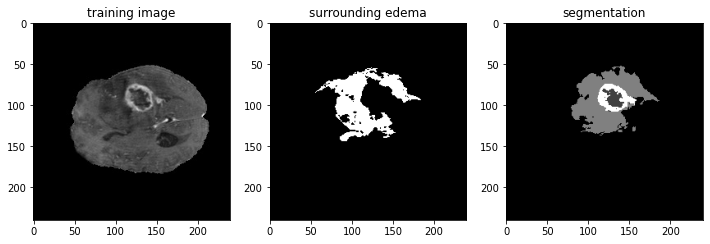

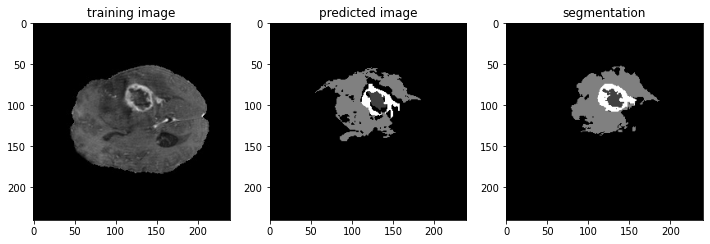

In [81]:
img_train, img_label = get_slice_mri(1, 72)
# Remove the noise : 
denoised    = denoise(img_train, method="bilateral") 
# Enhance contrast : 
enhanced    = adjust_contrast(denoised, method="histogram") 
# Sharpened : 
sharpened   = sharpen(denoised, method="laplacian")
# Multi thresholding : 
multithresh = thresholding(denoised, method='multi_otsu')

# background : 
background = thresholding(denoised, method="binary_inv", thresh=10)
# Reconstructed tumor : 
img_pred = np.zeros(img_label.shape)

# Necrotic non enhancing Tumor :
kernel = np.ones((2), np.uint8)
necrotic_tumor = np.copy(multithresh)
necrotic_tumor[necrotic_tumor < necrotic_tumor.max()] = 0
necrotic_tumor = np.uint8(necrotic_tumor)
necrotic_tumor = cv2.morphologyEx(necrotic_tumor, cv2.MORPH_ERODE, kernel, iterations=3)
ret, components = cv2.connectedComponents(necrotic_tumor)
necrotic_tumor[components != 3] = 0

# Enhancing Tumor : 
# It's included inside the necrotic tumor : 
enhancing_tumor = thresholding(enhanced, method='binary_inv', thresh=200)
ret, components = cv2.connectedComponents(enhancing_tumor)
enhancing_tumor[components != 2] = 0

# # Edema : 
edema = thresholding(enhanced, method='binary_inv', thresh=100)
edema = edema - background
ret, components = cv2.connectedComponents(edema)
edema[components !=6] = 0
necrotic_tumor = cv2.morphologyEx(necrotic_tumor, cv2.MORPH_CLOSE, kernel, iterations=3)

# img_pred : 
img_pred[enhancing_tumor == 255] =  50
img_pred[necrotic_tumor  ==   2] = 200
img_pred[edema           == 255] = 100

# Plot the image : 
compare_pred_seg(img_train, img_label, background,      pred_title="background")
compare_pred_seg(img_train, img_label, necrotic_tumor,  pred_title="Necrotic non enhancing Tumor")
compare_pred_seg(img_train, img_label, enhancing_tumor, pred_title="enhancing_tumor")
compare_pred_seg(img_train, img_label, edema,           pred_title="surrounding edema")
compare_pred_seg(img_train, img_label, img_pred,        pred_title="predicted image")

# Segmentation of the image using Superpixels : 

let's divide the image into superpixels : 

In [82]:
def draw_segmentation(img, superpixels):
    
    segmented      = np.copy(img)
    nb_superpixels = np.max(superpixels) 
    
    for label in range(1, nb_superpixels + 1):       
        idx            = superpixels == label
        segmented[idx] = np.mean(segmented[idx])
        
    img_boundaries = mark_boundaries(img, superpixels)
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("training image")
    
    ax[1].imshow(img_boundaries, cmap="gray")
    ax[1].set_title("boundaries of superpixels")
    
    ax[2].imshow(segmented, cmap="gray")
    ax[2].set_title("average intensity on superpixels")
    

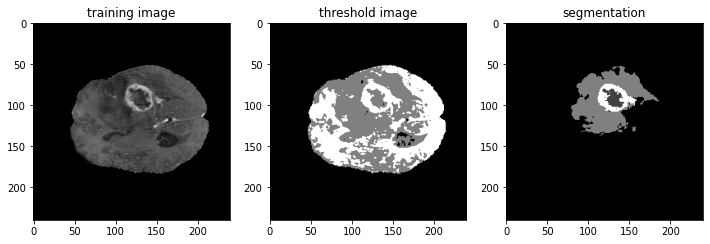

In [83]:
img_train, img_label = get_slice_mri(1, 72)
# Remove the noise : 
denoised  = denoise(img_train, method="bilateral") 
# threshold : 
thresh = thresholding(denoised, method="multi_otsu",)
# Plot the image : 
compare_pred_seg(img_train, img_label, thresh, pred_title="threshold image")

In [84]:
def get_superpixels_features(img, superpixels):
    # Image shape : 
    height, width = img.shape
    segmented     = np.copy(img)
    nb_superpixels = np.max(superpixels)
    
    # background : 
    background = thresholding(enhanced, method="binary_inv", thresh=12)
    # bilateral filter : 
    denoised = denoise(img, method='bilateral')
    # filter 1 : binary
    thresh_1 = thresholding(denoised, method="binary")
    # filter 2 : binary inv
    thresh_2 = thresholding(denoised, method="multi_otsu", thresh=60)
    thresh_2 = thresh_2 - background
    
    # Barycenter of superpixels : 
    x_idx = np.tile(range(width), height).reshape(height, width)
    y_idx = np.tile(range(height), width).reshape(height, width)
    
    # Superpixels features :
    sp_features = []
    for label in range(1, nb_superpixels + 1):
        # pixels belonging to to this superpixel :
        idx = superpixels == label
        color_feat, x_feat, y_feat = 0, 0, 0 
        
        # Features : 
        mean_feat      = np.mean(segmented[idx]) / 255 
        thresh_1_feat  = np.mean(thresh_1[idx])  / 255
        thresh_2_feat  = np.mean(thresh_2[idx])  / 255
        x_feat         = np.mean(x_idx[idx])     / (width - 1)
        y_feat         = np.mean(y_idx[idx])     / (height - 1)
          
        sp = [mean_feat, thresh_1_feat, x_feat, y_feat]
        sp_features.append(sp)

    return sp_features

## Create mask and Learning Data : 

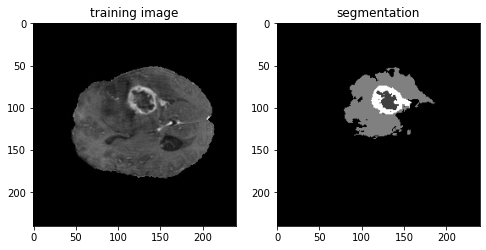

In [85]:
img_train, img_label = get_slice_mri(1, 72)
img_train_rgb, _     = get_slice_mri(1, 72, False)

# Plot the 72th slice of the first MRI and its label :
plot_slice_mri(1, 72)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


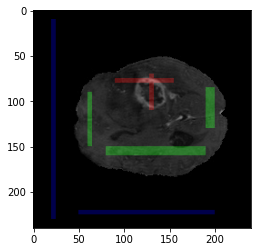

In [86]:
annotation = np.zeros(img_train.shape)

annotation[ 70: 110, 128: 133] = 1      # Tumor
annotation[ 75:  80,  90: 155] = 1      # Tumor
annotation[150: 160,  80: 190] = 2      # Normal Brain
annotation[ 85: 130, 190: 200] = 2      # Normal Brain
annotation[ 90: 150,  60:  65] = 2      # Normal Brain
annotation[ 10: 230,  20:  25] = 3      # Background
annotation[220: 225,  50: 200] = 3      # Background

img_annotation = np.zeros(img_train_rgb.shape)
img_annotation[annotation == 1] = [255, 0, 0]
img_annotation[annotation == 2] = [0, 255, 0]
img_annotation[annotation == 3] = [0, 0, 255]


plt.imshow(img_train_rgb, )
plt.imshow(img_annotation, alpha = 0.3)
plt.show()

In [87]:
def get_training_set(superpixels, sp_features, annotation, class_colors):

    X, y = [], []
    nb_superpixels = np.max(superpixels) 
    
    for label in range(1, nb_superpixels + 1): 
        # Check all pixels of this superpixel and check those that are attributed to each class :
        nb_pixels_per_class = []
        idx_sp = superpixels == label  
        
        for color in class_colors:
            learning_pixels = (annotation == color)
            common_idx      = np.logical_and(learning_pixels, idx_sp)
            nb_pixels_per_class.append(np.sum(common_idx))
            
        # Check if a superpixel contains only pixels of one single class :     
        class_idx = -1
        several_classes = False

        for idx in range(len(nb_pixels_per_class)):

            if nb_pixels_per_class[idx] > 0:
                if class_idx < 0:
                    # The Superpixel contains pixels belonging to a class : 
                    class_idx = idx
                else:
                    # The Superpixel contains pixels from different classes (can't be used for training) : 
                    several_classes = True

        # If a superpixel is retained as a learning data, let's stock its features and its Label : 

        if (class_idx >= 0) and not several_classes:
            y.append(class_colors[class_idx])
            X.append(sp_features[label - 1])
    
    return X, y

## Using Classifiers to detect cancer : 

In [88]:
def plot_decomposition(img, superpixels, probas, class_colors):
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    titles  = ["Tumor", "Normal brain", "background"]
    nb_superpixels = np.max(superpixels)
    
    for i in range(len(class_colors)):
        pixel_probas = np.zeros(img.shape)
        for label in range(1, nb_superpixels + 1):
            idx = superpixels == label
            pixel_probas[idx] = probas[label-1, i]
        
        sns.heatmap(pixel_probas, ax=ax[i], xticklabels=False, yticklabels=False)
        ax[i].set_title(titles[i])

In [89]:
def get_predicted_label(img, superpixels, probas):
    
    pixel_probas = np.zeros(img.shape)
    nb_superpixels = np.max(superpixels)
    for label in range(1, nb_superpixels+1):
        idx = superpixels == label
        pixel_probas[idx] = probas[label - 1, 0]

    img_pred = np.zeros(pixel_probas.shape)
    img_pred[pixel_probas >= 0.5] = 1
    
    return img_pred
    

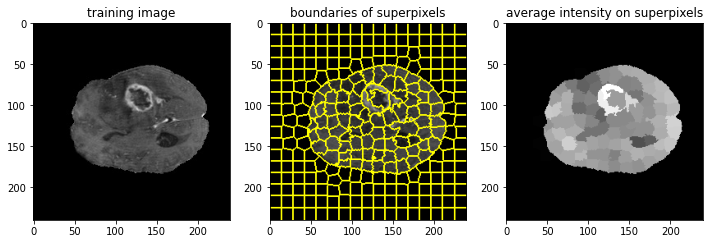

In [90]:
# Segment the image using SLIC algorithm : 
superpixels = slic(img_train, n_segments=300, compactness=0.1, multichannel=False, start_label=1)

draw_segmentation(img_train, superpixels)

# features of superpixels : 
sp_features = get_superpixels_features(img_train, superpixels)

# Class colors : 
class_colors = [1, 2, 3]

# Training set : 
(X, y) = get_training_set(superpixels, sp_features, annotation, class_colors)

## Using Gadient Boosting Classifier : 

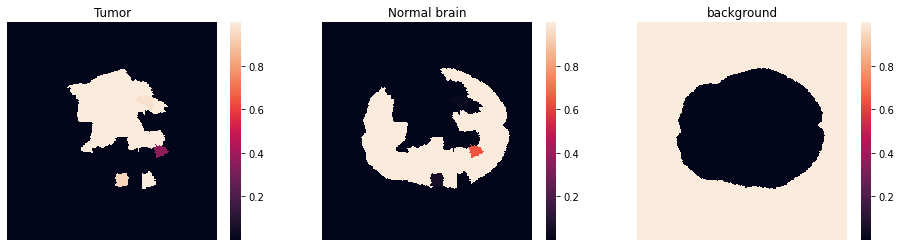

In [91]:
clf = GradientBoostingClassifier(max_depth=25)
clf.fit(X, y)

probas = clf.predict_proba(sp_features)
classification = clf.predict(sp_features)

plot_decomposition(denoised, superpixels, probas,  class_colors)

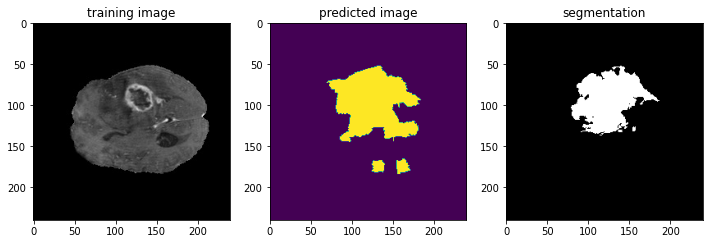

Dice coefficient:  0.7755772723341693


In [92]:
img_pred = get_predicted_label(img_train, superpixels, probas)

_img_label = np.zeros(img_label.shape)
_img_label[img_label > 25] = 1


compare_pred_seg(img_train, _img_label, img_pred, pred_title="predicted image", pred_gray=False)


Dice = (2 * np.sum(np.logical_and(img_pred, _img_label)))/(img_pred.sum() + _img_label.sum())
print('Dice coefficient: ', Dice)

## Using SVM Classifier : 

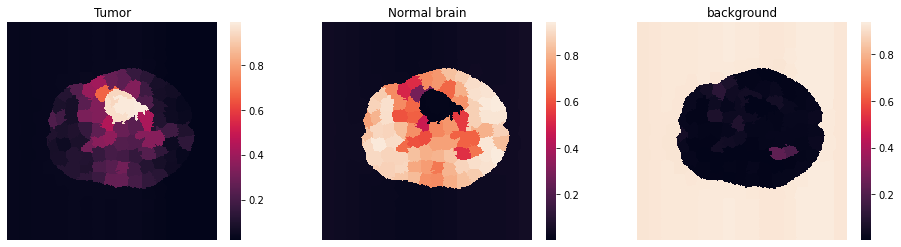

In [93]:
model_svm = svm.SVC(decision_function_shape='ovo')
model_svm.C = 4.
model_svm.gamma = 4.
model_svm.probability = True

model_svm.fit(X, y)

probas = model_svm.predict_proba(sp_features)
classification = model_svm.predict(sp_features)

plot_decomposition(img_train, superpixels, probas,  class_colors)

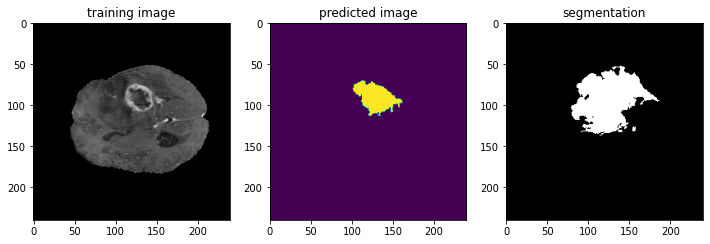

Dice coefficient:  0.4383780332056194


In [94]:
img_pred = get_predicted_label(img_train, superpixels, probas)

_img_label = np.zeros(img_label.shape)
_img_label[img_label > 25] = 1


compare_pred_seg(img_train, _img_label, img_pred, pred_title="predicted image", pred_gray=False)


Dice = (2 * np.sum(np.logical_and(img_pred, _img_label)))/(img_pred.sum() + _img_label.sum())
print('Dice coefficient: ', Dice)

## Using Normalized Cut : 

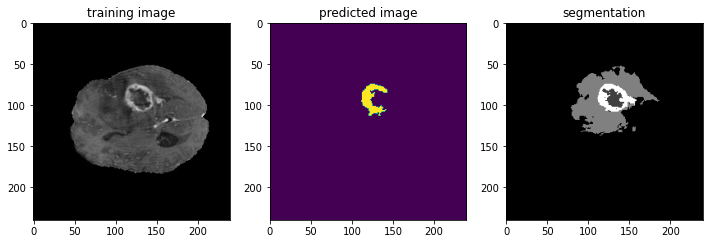

Dice coefficient:  0.21520381931692986


In [38]:
rag     = graph.rag_mean_color(img_train, superpixels, mode='similarity')
labels2 = graph.cut_normalized(superpixels, rag)

img_pred = np.zeros(labels2.shape)
img_pred[labels2 == labels2.max()] = 1

_img_label = np.zeros(img_label.shape)
_img_label[img_label > 25] = 1
compare_pred_seg(img_train, img_label, img_pred, pred_title="predicted image", pred_gray=False)


Dice = (2 * np.sum(np.logical_and(img_pred, _img_label)))/(img_pred.sum() + _img_label.sum())
print('Dice coefficient: ', Dice)

## Training set : 

Let's create a training dataset consisting of 25 MRIs : 

In [95]:
FEATURES = ["mean", 
            "variance",
            "enhanced_mean",
            "enhanced_variance",
            "sobel_mean",
            "sobel_variance",
            "sharpen_vanilla_mean",
            "sharpen_vanilla_variance"]

In [96]:
def create_features_labels(mri, slice, n_segments, features, compactness=0.1, multichannel=False, start_label=1):
    
    # Get the img_train and img_label from directory : 
    img_train, _img_label = get_slice_mri(mri, slice)
    # Remove noise from img_train using li_threshold: 
    foreground = thresholding(img_train, method="li")
    img_train[foreground == 0] = 0
    # Divide the image into superpixels : 
    superpixels = slic(img_train, n_segments, compactness, multichannel=multichannel, start_label=start_label)
    # Modify image_label : add normal brain cells and label them as 1, relabel enhancing tumor as 2, eudema as 3
    # and necrotic tumor as 4 : 
    img_label = foreground.copy().astype(np.uint8)
    img_label[_img_label ==  50] = 2 
    img_label[_img_label == 100] = 3
    img_label[_img_label == 200] = 4
    # Filters features : 
    enhanced = adjust_contrast(img_train, method='histogram') 
    sobel = sharpen(img_label, method="sobel")
    sharpen_vanilla = sharpen(img_train, method="vanilla")
    
    # create X_train, y_train : 
    X, y = [], []
    nb_superpixels = np.max(superpixels)
    for sp in range(1, nb_superpixels + 1):

        sp_pixels  = superpixels == sp
        # Add X_train : 
        X_feat = []
        if 'mean' in features :
            mean_feat = np.mean(img_train[sp_pixels]) / 255
            X_feat.append(mean_feat)

        if 'variance' in features :
            var_feat = np.var(img_train[sp_pixels]) / 255
            X_feat.append(var_feat)

        if 'enhanced_mean' in features:
            enhanced_mean_feat = np.mean(enhanced[sp_pixels]) / 255
            X_feat.append(enhanced_mean_feat)
            
        if 'enhanced_var' in features:
            enhanced_var_feat = np.var(enhanced[sp_pixels]) / 255
            X_feat.append(enhanced_mean_feat)
            
        if 'sobel_mean' in features:
            sobel_mean_feat = np.mean(sobel[sp_pixels]) / 255
            X_feat.append(sobel_mean_feat)

        if 'sobel_var' in features:
            sobel_var_feat = np.var(sobel[sp_pixels]) / 255
            X_feat.append(sobel_var_feat)
        
        if 'sharpen_vanilla_mean'in features:
            sharpen_vanilla_mean = np.mean(sharpen_vanilla[sp_pixels]) / 255
            X_feat.append(sharpen_vanilla_mean)

        if 'sharpen_vanilla_variance'in features:
            sharpen_vanilla_var = np.var(sharpen_vanilla[sp_pixels]) / 255
            X_feat.append(sharpen_vanilla_var)
            
        
            
        X.append(X_feat)
        
        # Add y_train : 
        occurences = Counter(img_label[sp_pixels])
        y.append(max(occurences.items(), key=operator.itemgetter(1))[0])
    
    X, y = np.array(X), np.array(y)
    
    
    return X, y, superpixels

In [97]:
def create_training_set(mris, slices, n_segments, features, compactness=0.1, multichannel=False, start_label=1):
    
    ''' Function that generates a training dataset of superpixels from the provided mris list 
    '''  
    X_train, y_train = [], []
    for mri in mris:
        description ="mri : " + shape(mri) + " / " + shape(len(mris))
        for slice in tqdm(slices, desc=description) :    
            _X_train, _y_train, _ = create_features_labels(mri, slice, n_segments, features,
                                                        compactness=0.1, multichannel=False, start_label=1)
            X_train.append(_X_train)
            y_train.append(_y_train)
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    return X_train, y_train
    

In [98]:
%%time
X_train, y_train = create_training_set(range(1, 5), range(50, 71), 1000, FEATURES,)

mri : 004 / 004: 100%|█████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.30it/s]

Wall time: 1min 4s


In [99]:
X_test, y_test, superpixels = create_features_labels(1, 62, 1000, FEATURES, compactness=0.1, multichannel=False, start_label=1)

In [105]:
def reconstruct_label(superpixels, y):
    img_label = np.zeros(superpixels.shape)
    nb_superpixels = superpixels.max()
    for sp in range(1, nb_superpixels+1):
        img_label[superpixels == sp] = y[sp-1]
    return img_label

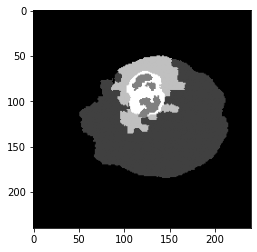

In [106]:
img_pred = reconstruct_label(superpixels, classification)
plt.imshow(img_pred, cmap='gray')

In [102]:
clf = GradientBoostingClassifier(max_depth=25)
clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=25)

In [103]:
probas = clf.predict_proba(X_test)
classification = clf.predict(X_test)

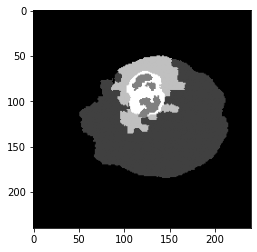

In [104]:
img_pred = reconstruct_label(superpixels, classification)
plt.imshow(img_pred, cmap='gray')

In [109]:
np.unique(img_pred)

array([0., 1., 2., 3., 4.])

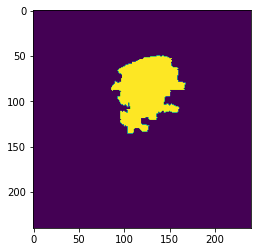

In [112]:
binary_label = np.logical_and(img_pred != 0, img_pred != 1)
plt.imshow(binary_label)